In [1]:
!pip install scikeras catboost
!pip install scikit-learn==1.1.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 47.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.1.3
    Uninstalling scikit-learn-1.1.3:
      Successfully uninstalled scikit-learn-1.1.3
  Using cached scikit_learn-1.1.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
Using cached scikit_learn-1.1.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (32.0 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikeras 0.13.0 requires scikit-learn>=1.4.2, but you have scikit-learn 1.1.3 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.1.3 which

In [2]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# import mlflow
# from mlflow.models import infer_signature

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, GridSearchCV, cross_val_score

# Machine Learning
from sklearn.metrics import r2_score, accuracy_score, precision_score, recall_score, log_loss
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# Others
import os
from tqdm import tqdm

# Set float format for pandas
pd.set_option('display.float_format', lambda x: '%.4f' % x)

np.random.seed(42)  # This sets the seed for numpy's random number generator

In [3]:
training_data   = pd.read_csv("https://raw.githubusercontent.com/maniconaji/EY_SmarCities/refs/heads/main/data/processed/training_data.csv").drop(columns = ["geometry"])
validation_data = pd.read_csv("https://raw.githubusercontent.com/maniconaji/EY_SmarCities/refs/heads/main/data/processed/validation_data.csv")

## Reading data

18


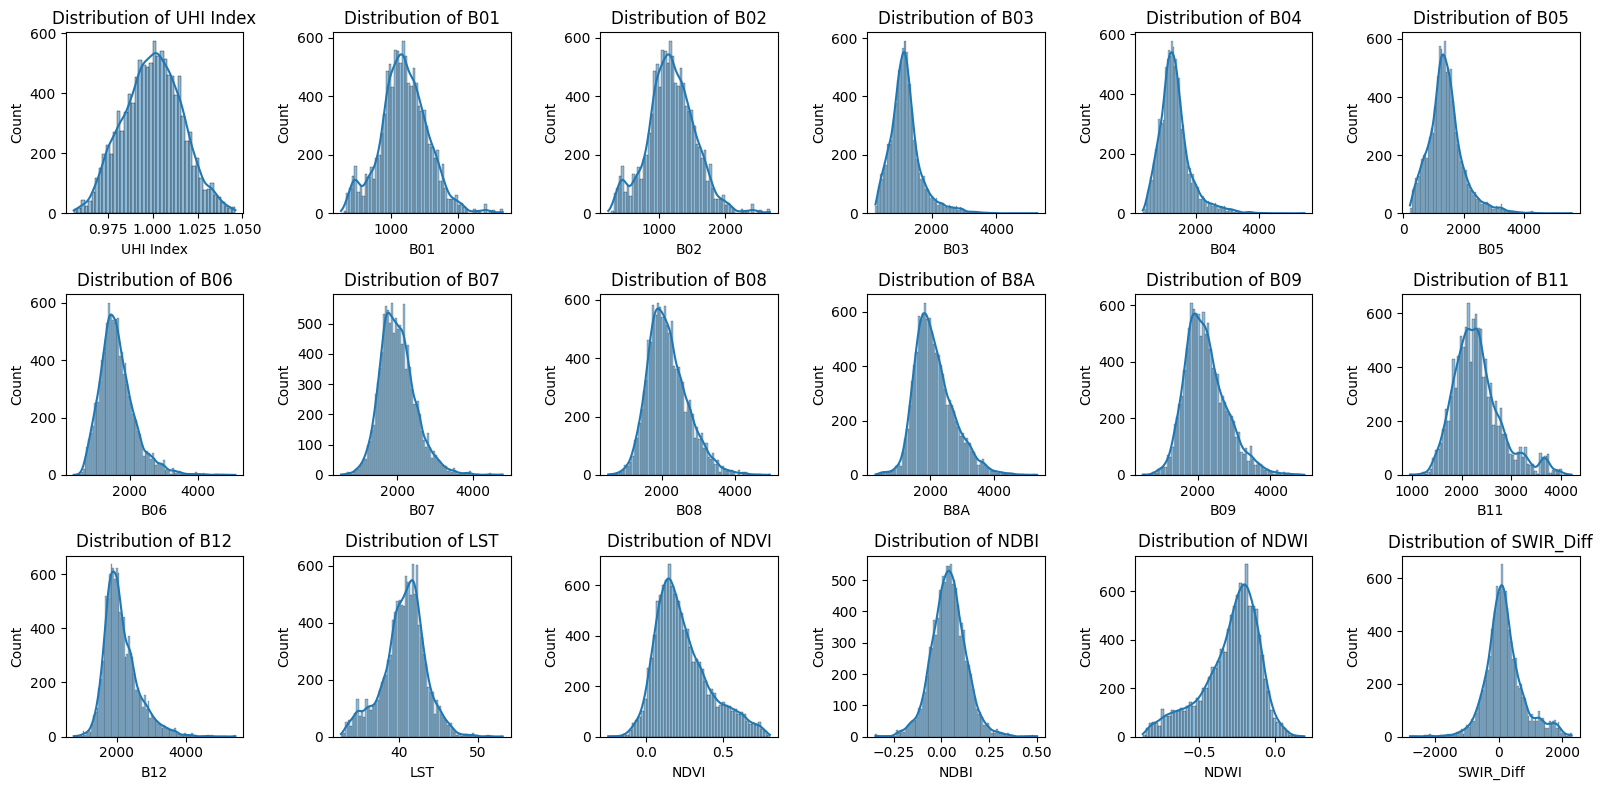

In [4]:
# Select columns to plot, excluding latitude, longitude, datetime

drop_columns    = ["Latitude", "Longitude", "datetime"] + ['air_temp', "wind_speed", "wind_dir", "solar_flux", "HR"]
columns_to_plot = [col for col in training_data.columns if col not in drop_columns]
print(len(columns_to_plot))
# Create the plot
plt.figure(figsize=(16, 8))

for i, column in enumerate(columns_to_plot):
    plt.subplot(3, 6, i + 1)  # Adjust subplot grid if needed
    sns.histplot(training_data[column], kde=True)
    plt.title(f'Distribution of {column}')

plt.tight_layout()
plt.show()

In [5]:
related_bands = ["B03", "B04", "B08", "B11", "B12"]

X = training_data.drop(columns=["UHI Index"] + drop_columns + related_bands)
y = training_data["UHI Index"]

In [6]:
import statsmodels.api as sm

X_clean = sm.add_constant(X)
y_clean = y

mod = sm.OLS(y_clean.reset_index(drop=True), X_clean.reset_index(drop=True))
res = mod.fit()
valid_cols = res.pvalues[res.pvalues < 0.05].index.to_list()[1:]

X_clean_drop = X_clean[valid_cols]
# Print summary
print("Valid columns:", valid_cols)
print(res.summary())

Valid columns: ['B01', 'B02', 'B05', 'B07', 'B8A', 'LST', 'NDVI', 'NDWI', 'SWIR_Diff']
                            OLS Regression Results                            
Dep. Variable:              UHI Index   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     226.2
Date:                Wed, 05 Mar 2025   Prob (F-statistic):               0.00
Time:                        21:39:41   Log-Likelihood:                 31460.
No. Observations:               11229   AIC:                        -6.290e+04
Df Residuals:                   11217   BIC:                        -6.281e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

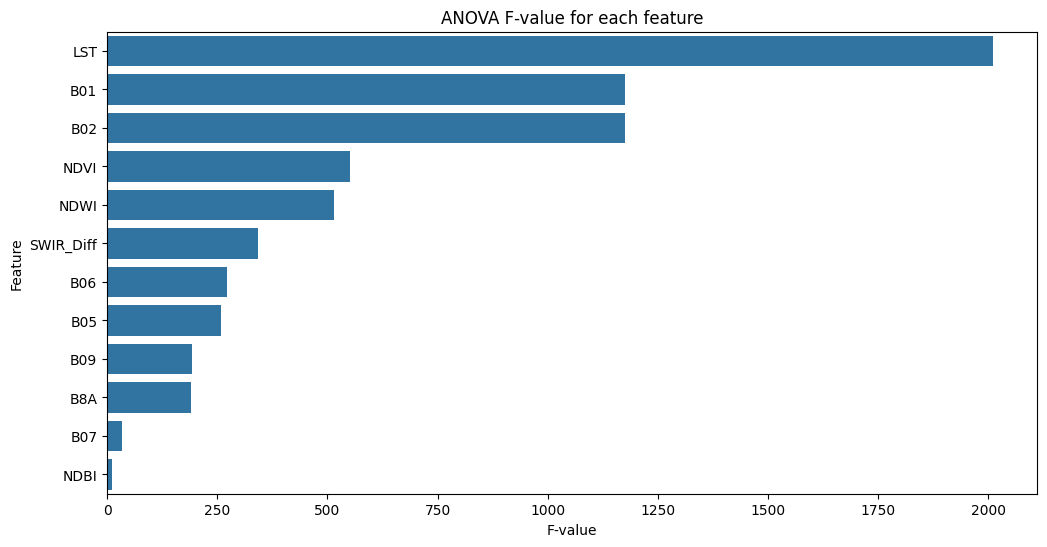


Explanation of ANOVA results:
The ANOVA test assesses the relationship between each feature and the target variable ('UHI Index').
The F-value represents the variance between the means of groups divided by the variance within each group.
A higher F-value indicates a stronger association between the feature and the target variable.
The p-value indicates the probability of observing the obtained results if there were no association.
Features with low p-values (typically < 0.05) suggest a statistically significant relationship with the target.
Features with high F-values and low p-values are likely important predictors for 'UHI Index'.
      Feature   F-value  p-value
7         LST 2009.9458   0.0000
0         B01 1175.7434   0.0000
1         B02 1175.7434   0.0000
8        NDVI  552.3246   0.0000
10       NDWI  515.3329   0.0000
11  SWIR_Diff  342.8601   0.0000
3         B06  272.3027   0.0000
2         B05  258.2876   0.0000
6         B09  192.9302   0.0000
5         B8A  190.5887   0.

In [7]:
# Assuming training_data_dropped is already defined from the previous code
X = X[X_clean.drop(columns = "const").columns]

# Apply StandardScaler
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Perform ANOVA F-value test
f_values, p_values = f_regression(X_scaled, y_clean)

# Create a DataFrame for results
anova_results = pd.DataFrame({'Feature': X.columns, 'F-value': f_values, 'p-value': p_values})
anova_results = anova_results.sort_values(by='F-value', ascending=False)

# Visualization of ANOVA results
plt.figure(figsize=(12, 6))
sns.barplot(x='F-value', y='Feature', data=anova_results)
plt.title('ANOVA F-value for each feature')
plt.xlabel('F-value')
plt.ylabel('Feature')
plt.show()

# Explanation of results
print("\nExplanation of ANOVA results:")
print("The ANOVA test assesses the relationship between each feature and the target variable ('UHI Index').")
print("The F-value represents the variance between the means of groups divided by the variance within each group.")
print("A higher F-value indicates a stronger association between the feature and the target variable.")
print("The p-value indicates the probability of observing the obtained results if there were no association.")
print("Features with low p-values (typically < 0.05) suggest a statistically significant relationship with the target.")
print("Features with high F-values and low p-values are likely important predictors for 'UHI Index'.")

# Display results
print(anova_results)

In [8]:
# Example of selecting top k features based on F-value
k_best = 5  # Choose the desired number of top features
selector = SelectKBest(score_func=f_regression, k=k_best)
X_new = selector.fit_transform(X_scaled, y)
X_val = validation_data[X.columns[selector.get_support()].to_list()]

print(f"\nSelected {k_best} best features based on ANOVA:\n{X.columns[selector.get_support()]}")


Selected 5 best features based on ANOVA:
Index(['B01', 'B02', 'LST', 'NDVI', 'NDWI'], dtype='object')


## Build Model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=42)

# Scale data (important for some models)
X_train   = scaler_X.fit_transform(X_train)
X_test  = scaler_X.transform(X_test)
X_val = scaler_X.transform(X_val)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler_y.transform(y_test.values.reshape(-1, 1))

Training RandomForest...
RandomForest R-squared: 0.6739

Training ExtraTrees...
ExtraTrees R-squared: 0.7379

Training HistGradientBoosting...
HistGradientBoosting R-squared: 0.4539

Training GradientBoosting...
GradientBoosting R-squared: 0.3285

Training XGBoost...
XGBoost R-squared: 0.6043

Training CatBoost...
CatBoost R-squared: 0.4856

Training LightGBM...
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 7860, number of used features: 5
[LightGBM] [Info] Start training from score 0.000000
LightGBM R-squared: 0.4593

Training MLP...
MLP R-squared: 0.2642



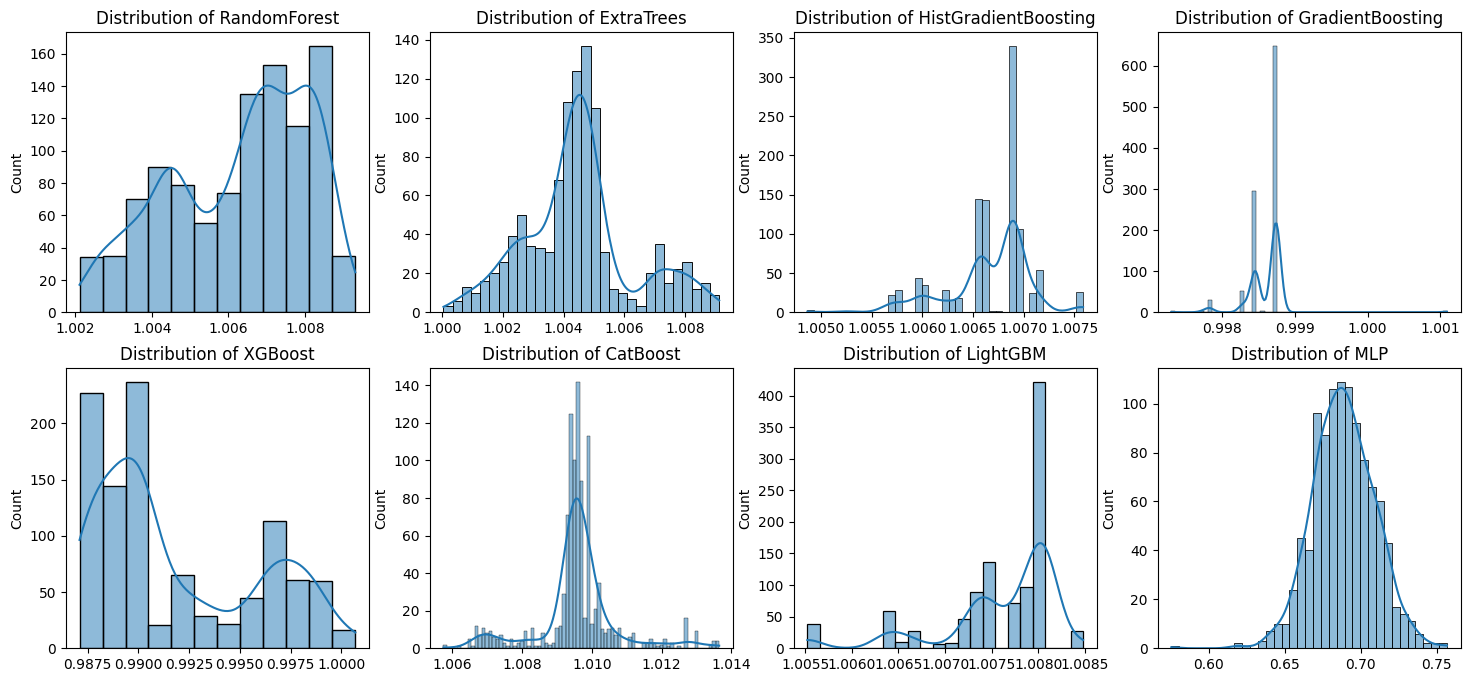

In [9]:
# Dictionary to store models and their R-squared scores
models = {
    "RandomForest": RandomForestRegressor(random_state=42),
    "ExtraTrees": ExtraTreesRegressor(random_state=42),
    "HistGradientBoosting": HistGradientBoostingRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42),
    "CatBoost": CatBoostRegressor(random_state=42, verbose=0),
    "LightGBM": LGBMRegressor(random_state=42, force_col_wise=True),
    "MLP": MLPRegressor(random_state=42),
}

save_models = {}

plt.figure(figsize=(18, 8))

# for i, column in enumerate(columns_to_plot):
#     plt.subplot(3, 6, i + 1)  # Adjust subplot grid if needed
#     sns.histplot(training_data[column], kde=True)
#     plt.title(f'Distribution of {column}')

# Train and evaluate each model
for i, (model_name, model) in enumerate(models.items()):
    print(f"Training {model_name}...")
    model.fit(X_train, y_train.ravel())  # Fit the model
    y_pred = model.predict(X_test)       # Make predictions
    r2 = r2_score(y_test, y_pred)          # Calculate R-squared

    f_pred = model.predict(X_val).reshape(-1,1)
    f_pred = scaler_y.inverse_transform(f_pred)
    f_pred = pd.Series(f_pred.squeeze())

    save_models[model_name] = {"model": model, "r2": r2}

    plt.subplot(2, 4, i + 1)  # Adjust subplot grid if needed
    sns.histplot(f_pred, kde=True)
    plt.title(f'Distribution of {model_name}')

    print(f"{model_name} R-squared: {r2:.4f}\n")

In [10]:
# param_grid = {
#     # 'n_estimators': np.arange(800, 1600 + 200, 200),  # Number of trees in the forest
#     # 'max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
#     # 'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
#     # 'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
#     'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider when looking for the best split
#     # 'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
# }

# # Create the ExtraTreesRegressor model
# model = ExtraTreesRegressor(random_state=42, **{'max_features': 'sqrt', 'n_estimators': 1200, 'min_samples_split': 2})

# # Create the GridSearchCV object
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=5, n_jobs=-1, verbose=2)

# # Fit the GridSearchCV object to your training data
# grid_search.fit(X_train, y_train)

# # Get the best hyperparameters and the best score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# print(f"Best Hyperparameters: {best_params}")
# print(f"Best R-squared: {best_score}")

In [11]:
# best_model = ExtraTreesRegressor(random_state=42, n_estimators=1200).fit(X_train, y_train.ravel())
# final_predictions = best_model.predict(X_val).reshape(-1,1)
# final_predictions = scaler_y.inverse_transform(final_predictions)
# final_prediction_series = pd.Series(final_predictions.squeeze())
# submission_df = pd.DataFrame({'Longitude':validation_data['Longitude'].values, 'Latitude':validation_data['Latitude'].values, 'UHI Index':final_prediction_series.values})
# submission_df.to_csv("submission.csv",index = False)

# plt.figure(figsize=(10, 6))
# sns.histplot(submission_df['UHI Index'], kde=True)
# plt.title('Distribution of UHI Index')
# plt.xlabel('UHI Index')
# plt.ylabel('Frequency')
# plt.show()

In [12]:
# best_model = save_models["RandomForest"]["model"]
# final_predictions = best_model.predict(X_val).reshape(-1,1)
# # final_predictions = scaler_y.inverse_transform(final_predictions)
# final_prediction_series = pd.Series(final_predictions.squeeze())
# submission_df = pd.DataFrame({'Longitude':validation_data['Longitude'].values, 'Latitude':validation_data['Latitude'].values, 'UHI Index':final_prediction_series.values})
# submission_df.to_csv("submission.csv",index = False)

In [13]:
# best_model = RandomForestRegressor(n_estimators = 800, random_state=42).fit(X_train, y_train)
# y_pred = best_model.predict(X_test)
# print(r2_score(y_test, y_pred))

In [14]:


# Define the hyperparameter grid XGBRFRegressor
# xgb_param_grid = {
#     'n_estimators': [700, 850, 1000],  # Ajustamos el rango para equilibrio entre complejidad y rendimiento
#     'max_depth': [4, 6, 8],  # Evitamos árboles demasiado profundos para no sobreajustar a la baja variabilidad de y
#     'learning_rate': [0.01, 0.03, 0.05],  # Tasa de aprendizaje baja para capturar pequeñas variaciones
#     'subsample': [0.8, 0.9, 1.0],  # Mantiene diversidad en los árboles sin perder generalización
#     'colsample_bytree': [0.7, 0.8, 0.9],  # Evita que el modelo dependa de todas las variables en cada árbol
#     'reg_lambda': [5, 10, 20],  # Regularización L2 más fuerte para controlar la variabilidad baja de y
#     'reg_alpha': [1, 5, 10],  # Regularización L1 para mayor estabilidad
# }
# Create an instance of the XGBRegressor
# model = xgb.XGBRFRegressor(random_state=42)

# # Define the hyperparameter grid RandomForestRegressor
# param_grid_rf = {
#     'n_estimators': [800, 1000],  # Número de árboles
#     'max_depth': [10, 20],         # Profundidad máxima de los árboles
#     'min_samples_split': [2, 5],   # Mínimo de muestras para dividir un nodo
#     'min_samples_leaf': [1, 2],    # Mínimo de muestras por hoja
# }
# # Create an instance of the RandomForestRegressor
# model = RandomForestRegressor(random_state=42)

# param_grid_gbr = {
#     'n_estimators': [200, 300],      # Número de árboles
#     'learning_rate': [0.05, 0.1],    # Tasa de aprendizaje
#     'max_depth': [3, 5],             # Profundidad máxima de los árboles
# }
# model = GradientBoostingRegressor(random_state=42)



# param_grid_catboost = {
#     'iterations': [500, 1000],     # Número de árboles
#     'learning_rate': [0.05, 0.1],  # Tasa de aprendizaje
#     'depth': [6, 10],              # Profundidad de los árboles
# }
# model = CatBoostRegressor(random_state=42, verbose=0)

# param_grid_hgb = {
#     'learning_rate': [0.05, 0.1],   # Tasa de aprendizaje
#     'max_iter': [300, 500],         # Iteraciones (equivalente a n_estimators)
#     'max_depth': [10, 20],          # Profundidad máxima
# }
# model = HistGradientBoostingRegressor(random_state=42)

# param_grid_lgbm = {
#     'n_estimators': [300, 500],     # Número de árboles
#     'learning_rate': [0.05, 0.1],   # Tasa de aprendizaje
#     'num_leaves': [31, 50],         # Controla la complejidad del modelo
# }
# model = LGBMRegressor(random_state=42)

# param_grid_mlp = {
#     'hidden_layer_sizes': [(50, 50), (100, 50), (100, 100)],  # Número de neuronas por capa
#     'activation': ['relu'],  # Función de activación
#     'alpha': [0.0001, 0.001],  # Regularización L2
#     'learning_rate_init': [0.001, 0.01],  # Tasa de aprendizaje
# }

# model = MLPRegressor(random_state=42, max_iter=1000)

# Create an instance of the KFold class
# kf = KFold(n_splits=10, random_state=42, shuffle=True)



In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Add
from tensorflow.keras.optimizers import RMSprop, Adam
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import numpy as np

# Define a function to create the model
def create_model(hidden_layer_sizes=(128, 64), activation='relu',
                 dropout_rate=0.2, optimizer='adam', learning_rate=0.01):
    # Define the input layer
    input_layer = Input(shape=(X_new.shape[1],))

    # Hidden layers
    x = Dense(hidden_layer_sizes[0], activation=activation)(input_layer)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(hidden_layer_sizes[1], activation=activation)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    # Output layer
    output_layer = Dense(1, activation='linear')(x)

    # Create the model
    model = keras.Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model


# Wrap the model with KerasRegressor, passing create_model as build_fn
model = KerasRegressor(model=create_model, verbose=0)

# Define the hyperparameter grid
param_grid = {
    'model__hidden_layer_sizes': [(128, 64), (256, 128)],
    'model__activation': ['relu', 'swish'],
    'model__dropout_rate': [0.2, 0.3],
    'model__optimizer': ['adam', 'rmsprop'],
    'model__learning_rate': [0.01, 0.001],
    'batch_size': [16, 32],
    'epochs': [50, 100]
}

# Create KFold object for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Create GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=kf)

# Fit the grid search to the data
grid_result = grid.fit(X_new, y)

# Get the best parameters and score
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Train the best model on the entire dataset
# Use model to build the final model with best parameters
best_model = model.set_params(**grid_result.best_params_).build()
best_model.fit(X_new, y)

KeyboardInterrupt: 

In [ ]:


tf.random.set_seed(42)

# Normalizar los datos con MinMaxScaler
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler_y.transform(y_test.values.reshape(-1, 1))

# Definir la arquitectura con skip connections (ResNet-like)
input_layer = Input(shape=(X_train.shape[1],))

x = Dense(256, activation="swish")(input_layer)
x = BatchNormalization()(x)

# Skip Connection 1
residual = x  # Guardamos la conexión residual
x = Dense(256, activation="swish")(x)
x = BatchNormalization()(x)
x = Add()([x, residual])  # Sumamos la conexión residual

x = Dense(128, activation="swish")(x)
x = BatchNormalization()(x)

# Skip Connection 2
residual = x
x = Dense(128, activation="swish")(x)
x = BatchNormalization()(x)
x = Add()([x, residual])

x = Dense(64, activation="swish")(x)
x = BatchNormalization()(x)

# Skip Connection 2
residual = x
x = Dense(64, activation="swish")(x)
x = BatchNormalization()(x)
x = Add()([x, residual])

x = Dense(32, activation="swish")(x)
x = Dropout(0.3)(x)

output_layer = Dense(1, activation="linear")(x)

model = keras.Model(inputs=input_layer, outputs=output_layer)


# Compilamos con RMSprop y un learning rate intermedio
optimizer = RMSprop(learning_rate=0.01)
model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

# Callbacks para Early Stopping
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-8),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
]

# Entrenar el modelo
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=500,
                    batch_size=16,
                    verbose=1,
                    callbacks=callbacks)

# Evaluar el modelo
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test MSE: {test_loss}, Test MAE: {test_mae}")

y_pred = model.predict(X_test).squeeze()
print(r2_score(y_test, y_pred))

In [ ]:
# results_df = pd.DataFrame(grid_search.cv_results_)
# results_df.to_csv("../data/results/results_MLPRegressor.csv", index=False)

In [ ]:
# if r2_score(y_test, y_pred) >= 0.8:
validation_data_transformed = scaler.transform(validation_data.drop(columns=["Latitude", "Longitude", "B03", "B04", "B08", "B11", "B12"] + ['air_temp', "wind_speed", "wind_dir", "solar_flux", "HR"]))
validation_data_transformed = pd.DataFrame(validation_data_transformed, columns = validation_data.columns[3:])

X_val = pd.DataFrame(validation_data_transformed[X.columns], columns = X.columns)
y_val = validation_data["UHI Index"]
final_predictions = best_model.predict(X_val).reshape(-1,1)
final_predictions = scaler_y.inverse_transform(final_predictions)
final_prediction_series = pd.Series(final_predictions.squeeze())
print(final_predictions)
submission_df = pd.DataFrame({'Longitude':validation_data['Longitude'].values, 'Latitude':validation_data['Latitude'].values, 'UHI Index':final_prediction_series.values})
submission_df.to_csv("submission.csv",index = False)
submission_df.head()